#LEVEL SET METHOD 

In [10]:
import numpy as np
from PIL import Image, ImageOps, ImageFilter, ImageDraw
from sklearn.metrics import mean_squared_error
import glob
import time

In [11]:
base_folder = 'Samples'
samples = sorted(glob.glob(base_folder + '/*'))

In [12]:
def default_phi(x, mode = 1, width = 5):
    # Initialize surface phi at the border ( width px from the border) of the image
    # or at the center of the image as a width by width square
    # i.e. 1 outside the curve, and -1 inside the curve
    if mode == 1:
        phi = -1*np.ones([x.size[1],x.size[0]])
        phi[int(x.size[1]/2)-width:int(x.size[1]/2)+width, int(x.size[0]/2)-width:int(x.size[0]/2)+width] = 1
    elif mode == 2:
        phi = 1.*np.ones([x.size[1],x.size[0]])
        phi[5:x.size[1]-width, width:x.size[0]-width] = -1.
    return phi  

#Level set Boundary evolution
def lss(img, dt = 1, freq = 20, rad = 3):
    img = img.convert('L')
    img = img - np.mean(img)  
    img = Image.fromarray(img).convert('L')
    u = default_phi(img, mode = 2)
    dx, dy = np.gradient(img.filter(ImageFilter.GaussianBlur(radius = rad)))
    Du = np.sqrt(dx**2 + dy**2)
    v = 1./(1. + Du)
    data = []
    data.append(Du)
    data.append(u)
    u_old = u
    niter = 0
    MSE_OLD = 1e+03
    change = 1e+03
    while change > 1e-15:
        niter += 1
        dx, dy = np.gradient(u)
        Du = np.sqrt(dx**2 + dy**2)
        u += dt * v * Du 
        u = np.where(u<0,-1.,1.)
        MSE = mean_squared_error(u_old, u)
        u_old = u
        change = abs(MSE - MSE_OLD)
        MSE_OLD = MSE
        if niter%freq == 0:
           data.append(u)     
    u = np.where(u<0,1.,0.)
    data.append(u)
    return data, niter 

In [13]:
#Plots the level set on the original image
def plot_boundary(img, segment):
  rad = 3
  img = img.convert("RGB")
  edge = Image.fromarray(segment).convert("L").filter(ImageFilter.GaussianBlur(radius = rad)).filter(ImageFilter.FIND_EDGES)
  for x in range(rad,img.size[0]-rad):
      for y in range(rad,img.size[1]-rad):
        if edge.getpixel((x,y)) != 0:
            for i in [-1,0,1]:
                for j in [-1,0,1]:
                    img.putpixel( (x+i,y+j), (255,0,255) )
        
  return img

#Saves the boundary evolution as a gif file
def evolution_gif(img, data, file_name = 'dummy.gif', duration = 400, loop = 2):
  images = []
  for i in range(2,len(data)):
    tmp =plot_boundary(img, data[i])  
    images.append(tmp)

  images[0].save(file_name, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=loop)

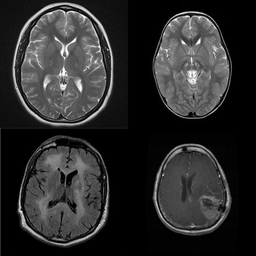

In [26]:
img = Image.open(samples[2])
display(img)

In [27]:
#Perform level set boundary evolution on the MRI image
data, niter = lss(img,dt = 1, freq = 10)

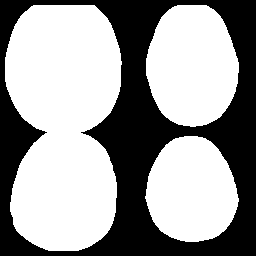

In [28]:
#Show the converged boundary as a binary mask image
display(ImageOps.autocontrast(Image.fromarray(data[-1]).convert('L')))

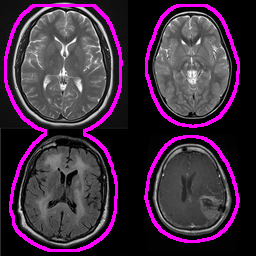

In [29]:
#Show the converged boundary on the original MRI image
display(plot_boundary(img, data[-1]))

In [30]:
#Create a gif of the boundary evolution in time
timestr = time.strftime("%Y%m%d-%H%M%S") 
evolution_gif(img, data, file_name = timestr+'.gif', duration=800, loop=2)